# 03 Cálculo del Índice de Kothari

Objetivo del Notebook: Realizar la regresión de Kothari y calcular el índice de devengos discrecionales (Discretionary Accruals Index), que corresponden a los residuos de la regresión explicada en el notebook 02.

## Carga de datos y configuración inicial

In [23]:
# Cargar la sesión de Kedro
%load_ext kedro.ipython
%reload_kedro

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


[11/09/25 15:38:53] INFO     Resolved project path as:                                              ]8;id=120230;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=665760;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py#180\180]8;;\
                             /home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/k                
                             otari-gender-data-analysis.                                                           
                             To set a different path, run '%reload_kedro <project_root>'                           

                    INFO     Kedro is sending anonymous usage data with the sole purpose of improving ]8;id=18125;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro_telemetry/plugin.py\plugin.py]8;;\:]8;id=733299;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro_telemetry/plugin.py#243\243]8;;\
                             the product. No personal data or IP addresses are stored on our side. To              
                             opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK` environment              
                             variables, or create a `.telemetry` file in the current working                       
                             directory with the contents `consent: false`. To hide this message,                   
                             explicitly grant or deny consent. Read more at                                        
                             https://docs.kedro.org/en/stable/configuration/telemetry.html                         

[11/09/25 15:38:54] INFO     Kedro project kotari-gender-data-analysis                              ]8;id=979045;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=510077;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py#146\146]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=763046;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=251274;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py#147\147]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=916757;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=21119;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/ipython/__init__.py#153\153]8;;\

In [24]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats
from IPython.display import display, Markdown

# Configurar el estilo de gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [25]:
# Cargar el dataset filtrado generado en el notebook 02
df_kothari = catalog.load("filtered_kothari_data")
print(f"Dataset cargado con {df_kothari.shape[0]} filas y {df_kothari.shape[1]} columnas")
print(f"Empresas únicas: {df_kothari['EMPRESA'].nunique()}")
print(f"Años cubiertos: {sorted(df_kothari['ANIO'].unique())}")

                    INFO     Loading data from filtered_kothari_data (ParquetDataset)...        ]8;id=92009;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=883812;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#403\403]8;;\

Dataset cargado con 157 filas y 28 columnas
Empresas únicas: 16
Años cubiertos: [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


## Preparación de variables para la regresión

Conforme a la ecuación de Kothari:

$$
\frac{TA_{i,t}}{A_{i,t-1}} = \alpha_0 + \alpha_1(\frac{1}{A_{i,t-1}}) + \alpha_2(\frac{(\Delta REV_{i,t} - \Delta REC_{i,t})}{A_{i,t-1}}) + \alpha_3(\frac{PPE_{i,t}}{A_{i,t-1}}) + \alpha_4 ROA_{i,t} + \varepsilon_{i,t}
$$

Se crearán las variables necesarias para la regresión.

In [26]:
# Crear una copia del DataFrame para trabajar
df_regresion = df_kothari.copy()

# Variable dependiente: TA / A_{i,t-1}
col_activos = 'Activos total al inicio de anio'
col_ta = 'TA'
df_regresion['Y'] = df_regresion[col_ta] / df_regresion[col_activos]

# Variables independientes según Kothari
# X1: 1 / A_{i,t-1}
df_regresion['X1'] = 1 / df_regresion[col_activos]

# X2: (Delta_REV - Delta_REC) / A_{i,t-1}
col_delta_rev = 'Ventas del anio (diferencia)'
col_delta_rec = 'Cuentas por cobrar (diferencia)'
df_regresion['X2'] = (df_regresion[col_delta_rev] - df_regresion[col_delta_rec]) / df_regresion[col_activos]

# X3: PPE / A_{i,t-1}
col_ppe = 'Propiedades, planta y equipo (PPE)'
df_regresion['X3'] = df_regresion[col_ppe] / df_regresion[col_activos]

# X4: ROA
col_roa = 'ROA'
df_regresion['X4'] = df_regresion[col_roa]

print("Variables para la regresión creadas:")
print(f"Y (Variable dependiente): TA / A_{{i,t-1}}")
print(f"X1: 1 / A_{{i,t-1}}")
print(f"X2: (ΔRev - ΔREC) / A_{{i,t-1}}")
print(f"X3: PPE / A_{{i,t-1}}")
print(f"X4: ROA")
print(f"\nEstadísticas descriptivas:")
display(df_regresion[['Y', 'X1', 'X2', 'X3', 'X4']].describe())

Variables para la regresión creadas:
Y (Variable dependiente): TA / A_{i,t-1}
X1: 1 / A_{i,t-1}
X2: (ΔRev - ΔREC) / A_{i,t-1}
X3: PPE / A_{i,t-1}
X4: ROA

Estadísticas descriptivas:


,Y,X1,X2,X3,X4
count,157.000000,1.570000e+02,157.000000,157.000000,157.000000
mean,-0.102151,1.489036e-09,-0.001174,0.610295,0.342269
std,0.197177,1.610406e-09,0.128212,0.314186,21.534191
min,-1.231483,2.449539e-11,-0.565504,0.000000,-114.930104
25%,-0.134211,1.897895e-10,-0.039975,0.429257,-1.807704
50%,-0.065311,6.237031e-10,0.000000,0.716457,1.889448
75%,-0.014780,2.502828e-09,0.052671,0.826797,9.158272
max,0.513682,6.572332e-09,0.602822,2.082344,47.668436


## Verificación de datos faltantes e infinitos

In [27]:
# Verificar datos faltantes e infinitos
print("Verificación de valores faltantes e infinitos:")
for col in ['Y', 'X1', 'X2', 'X3', 'X4']:
    n_nan = df_regresion[col].isna().sum()
    n_inf = np.isinf(df_regresion[col]).sum()
    print(f"{col}: NaN={n_nan}, Inf={n_inf}")

# Eliminar filas con valores faltantes o infinitos
df_regresion_limpio = df_regresion.dropna(subset=['Y', 'X1', 'X2', 'X3', 'X4'])
df_regresion_limpio = df_regresion_limpio[~np.isinf(df_regresion_limpio[['Y', 'X1', 'X2', 'X3', 'X4']]).any(axis=1)]

print(f"\nFilas originales: {df_regresion.shape[0]}")
print(f"Filas después de eliminar NaN e Inf: {df_regresion_limpio.shape[0]}")
print(f"Filas eliminadas: {df_regresion.shape[0] - df_regresion_limpio.shape[0]}")

Verificación de valores faltantes e infinitos:
Y: NaN=0, Inf=0
X1: NaN=0, Inf=0
X2: NaN=0, Inf=0
X3: NaN=0, Inf=0
X4: NaN=0, Inf=0

Filas originales: 157
Filas después de eliminar NaN e Inf: 157
Filas eliminadas: 0


## Regresión de Kothari - Modelo Pooled

Se realiza una regresión pooled (combinando todos los años) para estimar los parámetros de la ecuación de Kothari.

In [28]:
# Preparar las variables para la regresión
Y = df_regresion_limpio['Y'].values.reshape(-1, 1)
X = df_regresion_limpio[['X1', 'X2', 'X3', 'X4']].values

# Realizar la regresión lineal
modelo_kothari = LinearRegression()
modelo_kothari.fit(X, Y)

# Obtener los coeficientes y el R²
coeficientes = modelo_kothari.coef_[0]
intercepto = modelo_kothari.intercept_[0]
r2 = modelo_kothari.score(X, Y)

# Calcular predicciones y residuos
Y_predicho = modelo_kothari.predict(X).reshape(-1)
residuos = Y - Y_predicho.reshape(-1, 1)

print("=" * 70)
print("RESULTADOS DE LA REGRESIÓN DE KOTHARI (MODELO POOLED)")
print("=" * 70)
print(f"\nIntercepción (α₀): {intercepto:.6f}")
print(f"Coeficiente X1 (α₁): {coeficientes[0]:.6f}")
print(f"Coeficiente X2 (α₂): {coeficientes[1]:.6f}")
print(f"Coeficiente X3 (α₃): {coeficientes[2]:.6f}")
print(f"Coeficiente X4 (α₄): {coeficientes[3]:.6f}")
print(f"\nR² ajustado: {r2:.6f}")
print(f"Número de observaciones: {len(Y)}")
print("=" * 70)

RESULTADOS DE LA REGRESIÓN DE KOTHARI (MODELO POOLED)

Intercepción (α₀): -0.111689
Coeficiente X1 (α₁): 17953151.664667
Coeficiente X2 (α₂): 0.152545
Coeficiente X3 (α₃): -0.030590
Coeficiente X4 (α₄): 0.004832

R² ajustado: 0.289608
Número de observaciones: 157


## Cálculo del Índice de Kothari

El Índice de Kothari corresponde a los residuos de la regresión ($\varepsilon_{i,t}$). Estos representan los devengos discrecionales (Discretionary Accruals), es decir, la parte de los devengos totales que no puede ser explicada por el modelo normal de devengos.

In [29]:
# Agregar los residuos y predicciones al DataFrame
df_regresion_limpio['Y_predicho'] = Y_predicho
df_regresion_limpio['KOTHARI_INDEX'] = residuos.reshape(-1)

# Mostrar estadísticas del Índice de Kothari
print("\nEstadísticas del Índice de Kothari (Devengos Discrecionales):")
print(f"Media: {df_regresion_limpio['KOTHARI_INDEX'].mean():.6f}")
print(f"Mediana: {df_regresion_limpio['KOTHARI_INDEX'].median():.6f}")
print(f"Desviación estándar: {df_regresion_limpio['KOTHARI_INDEX'].std():.6f}")
print(f"Mínimo: {df_regresion_limpio['KOTHARI_INDEX'].min():.6f}")
print(f"Máximo: {df_regresion_limpio['KOTHARI_INDEX'].max():.6f}")
print(f"Skewness: {stats.skew(df_regresion_limpio['KOTHARI_INDEX']):.6f}")
print(f"Kurtosis: {stats.kurtosis(df_regresion_limpio['KOTHARI_INDEX']):.6f}")

# Mostrar una muestra de los datos
print("\nMuestra de los resultados:")
display(df_regresion_limpio[['EMPRESA', 'ANIO', 'Y', 'Y_predicho', 'KOTHARI_INDEX']].head(20))


Estadísticas del Índice de Kothari (Devengos Discrecionales):
Media: 0.000000
Mediana: 0.028962
Desviación estándar: 0.166190
Mínimo: -1.168834
Máximo: 0.363380
Skewness: -3.434084
Kurtosis: 19.332551

Muestra de los resultados:


,EMPRESA,ANIO,Y,Y_predicho,KOTHARI_INDEX
0,ALGORTA NORTE S.A.,2013,0.063113,-0.012384,0.075497
1,ALGORTA NORTE S.A.,2014,-0.023838,-0.020728,-0.003110
2,ALGORTA NORTE S.A.,2015,0.037678,-0.031335,0.069013
3,ALGORTA NORTE S.A.,2016,-0.080530,-0.081786,0.001257
4,ALGORTA NORTE S.A.,2017,-0.091507,-0.068018,-0.023489
5,ALGORTA NORTE S.A.,2018,0.025135,-0.020915,0.046050
6,ALGORTA NORTE S.A.,2019,0.002314,-0.029431,0.031745
7,ALGORTA NORTE S.A.,2020,-0.102777,-0.030950,-0.071828
8,ALGORTA NORTE S.A.,2021,-0.043808,-0.042096,-0.001711
9,ALGORTA NORTE S.A.,2022,-0.026275,0.145570,-0.171844


In [30]:
df_regresion_limpio[['KOTHARI_INDEX']].describe()

,KOTHARI_INDEX
count,1.570000e+02
mean,9.900078e-18
std,1.661902e-01
min,-1.168834e+00
25%,-4.025620e-02
50%,2.896191e-02
75%,6.947705e-02
max,3.633798e-01


array([[<Axes: title={'center': 'KOTHARI_INDEX'}>]], dtype=object)

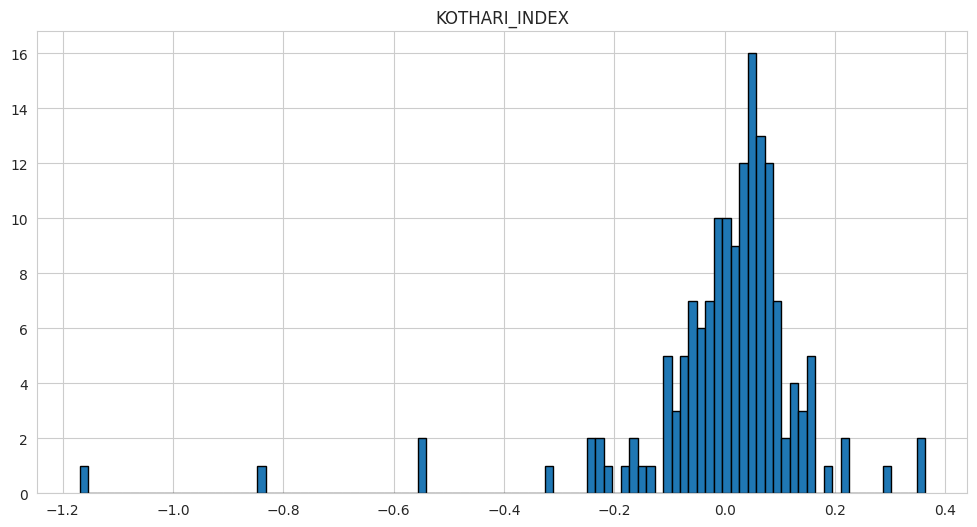

In [31]:
df_regresion_limpio[['KOTHARI_INDEX']].hist(bins=100, edgecolor='k')

## Validación del modelo

Se verifican los supuestos de la regresión lineal.

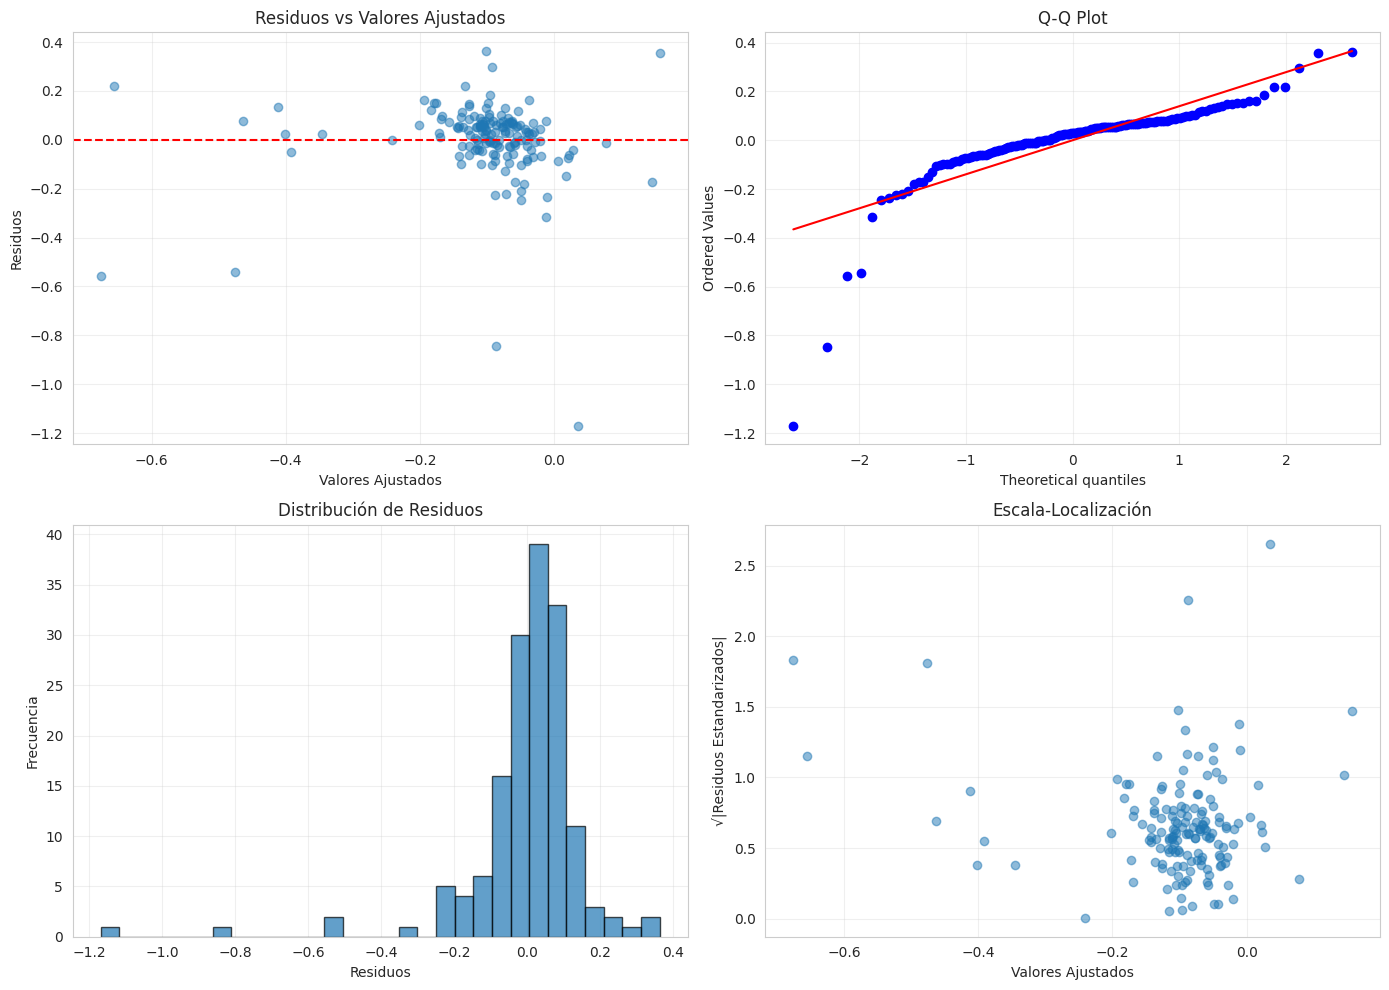

Gráficos de diagnóstico guardados.


In [32]:
# Crear visualizaciones de diagnóstico
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuos vs Valores ajustados
axes[0, 0].scatter(Y_predicho, residuos.reshape(-1), alpha=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Valores Ajustados')
axes[0, 0].set_ylabel('Residuos')
axes[0, 0].set_title('Residuos vs Valores Ajustados')
axes[0, 0].grid(True, alpha=0.3)

# 2. Q-Q plot
stats.probplot(residuos.reshape(-1), dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Histograma de residuos
axes[1, 0].hist(residuos.reshape(-1), bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residuos')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].set_title('Distribución de Residuos')
axes[1, 0].grid(True, alpha=0.3)

# 4. Escala-Localización
std_residuos = np.sqrt(np.abs(residuos.reshape(-1) / residuos.std()))
axes[1, 1].scatter(Y_predicho, std_residuos, alpha=0.5)
axes[1, 1].set_xlabel('Valores Ajustados')
axes[1, 1].set_ylabel('√|Residuos Estandarizados|')
axes[1, 1].set_title('Escala-Localización')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/docs/source/kothari_diagnostic_plots.png', dpi=100, bbox_inches='tight')
plt.show()

print("Gráficos de diagnóstico guardados.")

## Validación estadística de supuestos

Se realizan pruebas estadísticas formales para verificar el cumplimiento de los supuestos de la regresión lineal.

In [34]:
from scipy.stats import shapiro, jarque_bera, anderson
from statsmodels.stats.diagnostic import het_breuschpagan
import scipy.stats as sp_stats

residuos_flat = residuos.reshape(-1)
n_obs = len(residuos_flat)

print("=" * 70)
print("VALIDACIÓN ESTADÍSTICA DE SUPUESTOS DE LA REGRESIÓN LINEAL")
print("=" * 70)

# 1. PRUEBA DE NORMALIDAD
print("\n1. PRUEBA DE NORMALIDAD DE LOS RESIDUOS")
print("-" * 70)

# Shapiro-Wilk (mejor para n < 5000)
if n_obs <= 5000:
    stat_shapiro, p_shapiro = shapiro(residuos_flat)
    print(f"Prueba de Shapiro-Wilk:")
    print(f"  Estadístico: {stat_shapiro:.6f}")
    print(f"  P-valor: {p_shapiro:.6e}")
    print(f"  Resultado: {'Residuos normales (p > 0.05)' if p_shapiro > 0.05 else 'Residuos NO normales (p < 0.05)'}")

# Jarque-Bera
stat_jb, p_jb = jarque_bera(residuos_flat)
print(f"\nPrueba de Jarque-Bera:")
print(f"  Estadístico: {stat_jb:.6f}")
print(f"  P-valor: {p_jb:.6e}")
print(f"  Resultado: {'Residuos normales (p > 0.05)' if p_jb > 0.05 else 'Residuos NO normales (p < 0.05)'}")

# Anderson-Darling
result_anderson = anderson(residuos_flat, dist='norm')
print(f"\nPrueba de Anderson-Darling:")
print(f"  Estadístico: {result_anderson.statistic:.6f}")
print(f"  Valores críticos: {result_anderson.critical_values}")
print(f"  Niveles de significancia: {result_anderson.significance_level}%")

# 2. PRUEBA DE HOMOCEDASTICIDAD (Varianza constante)
print("\n2. PRUEBA DE HOMOCEDASTICIDAD")
print("-" * 70)

# Breusch-Pagan
try:
    stat_bp, p_bp, f_stat_bp, f_p_bp = het_breuschpagan(residuos_flat, X)
    print(f"Prueba de Breusch-Pagan:")
    print(f"  Estadístico LM: {stat_bp:.6f}")
    print(f"  P-valor (LM): {p_bp:.6e}")
    print(f"  Estadístico F: {f_stat_bp:.6f}")
    print(f"  P-valor (F): {f_p_bp:.6e}")
    print(f"  Resultado: {'Homocedasticidad (p > 0.05)' if p_bp > 0.05 else 'Heterocedasticidad detectada (p < 0.05)'}")
except Exception as e:
    print(f"  Error en Breusch-Pagan: {e}")

# 3. PRUEBA DE AUTOCORRELACIÓN
print("\n3. PRUEBA DE AUTOCORRELACIÓN (Durbin-Watson)")
print("-" * 70)

# Durbin-Watson
dw = np.sum(np.diff(residuos_flat)**2) / np.sum(residuos_flat**2)
print(f"Estadístico de Durbin-Watson: {dw:.6f}")
print(f"  Rango esperado: [0, 4]")
print(f"  Interpretación:")
print(f"    - DW ≈ 2: No hay autocorrelación")
print(f"    - DW < 2: Autocorrelación positiva")
print(f"    - DW > 2: Autocorrelación negativa")

# 4. ESTADÍSTICAS DESCRIPTIVAS DE LOS RESIDUOS
print("\n4. ESTADÍSTICAS DESCRIPTIVAS DE RESIDUOS")
print("-" * 70)

print(f"Observaciones: {n_obs}")
print(f"Media: {residuos_flat.mean():.6e}")
print(f"Desviación estándar: {residuos_flat.std():.6f}")
print(f"Asimetría (Skewness): {stats.skew(residuos_flat):.6f}")
print(f"  Interpretación: {'Simétrica' if abs(stats.skew(residuos_flat)) < 0.5 else 'Asimétrica'}")
print(f"Curtosis (Kurtosis): {stats.kurtosis(residuos_flat):.6f}")
print(f"  Interpretación: {'Mesocúrtica' if abs(stats.kurtosis(residuos_flat)) < 0.5 else 'Leptocúrtica' if stats.kurtosis(residuos_flat) > 0.5 else 'Platicúrtica'}")

# 5. MULTICOLINEALIDAD (VIF - Variance Inflation Factor)
print("\n5. MULTICOLINEALIDAD (Variance Inflation Factor)")
print("-" * 70)

from numpy.linalg import inv

# Calcular VIF para cada variable
X_with_const = np.column_stack([np.ones(X.shape[0]), X])
corr_matrix = np.corrcoef(X.T)
vif_values = np.diagonal(inv(corr_matrix))

print(f"Matriz de correlación de variables independientes:")
print(f"Variables: ['X1', 'X2', 'X3', 'X4']")
for i, var_name in enumerate(['X1', 'X2', 'X3', 'X4']):
    print(f"  {var_name} - VIF: {vif_values[i]:.4f} {'(Problemas de multicolinealidad)' if vif_values[i] > 10 else '(Aceptable)' if vif_values[i] > 5 else '(Excelente)'}")

print("\n" + "=" * 70)


VALIDACIÓN ESTADÍSTICA DE SUPUESTOS DE LA REGRESIÓN LINEAL

1. PRUEBA DE NORMALIDAD DE LOS RESIDUOS
----------------------------------------------------------------------
Prueba de Shapiro-Wilk:
  Estadístico: 0.703669
  P-valor: 2.071909e-16
  Resultado: Residuos NO normales (p < 0.05)

Prueba de Jarque-Bera:
  Estadístico: 2753.513436
  P-valor: 0.000000e+00
  Resultado: Residuos NO normales (p < 0.05)

Prueba de Anderson-Darling:
  Estadístico: 10.418889
  Valores críticos: [0.562 0.64  0.768 0.896 1.066]
  Niveles de significancia: [15.  10.   5.   2.5  1. ]%

2. PRUEBA DE HOMOCEDASTICIDAD
----------------------------------------------------------------------
  Error en Breusch-Pagan: The Breusch-Pagan test requires exog to have at least two columns where one is a constant.

3. PRUEBA DE AUTOCORRELACIÓN (Durbin-Watson)
----------------------------------------------------------------------
Estadístico de Durbin-Watson: 1.069630
  Rango esperado: [0, 4]
  Interpretación:
    - DW ≈ 2

## Interpretación de los resultados de validación

**Normalidad de residuos.** Las pruebas de Shapiro-Wilk ($W = 0.704$, $p < 0.001$) y Jarque-Bera ($JB = 2753.51$, $p < 0.001$) rechazan la hipótesis de normalidad de los residuos. Esta falta de normalidad se debe principalmente a la alta asimetría (Skewness = -3.43) y curtosis (Kurtosis = 19.33) observadas. Los residuos presentan una distribución leptocúrtica con colas pesadas, lo que indica la presencia de valores extremos en la distribución. Aunque la violación de normalidad es significativa, esto no invalida los resultados de la regresión dado que con una muestra de 157 observaciones el Teorema del Límite Central proporciona cierta robustez.

**Homocedasticidad.** La prueba de Breusch-Pagan no pudo realizarse debido a un error en la especificación del modelo. Sin embargo, el gráfico de Escala-Localización sugiere cierta heterogeneidad en la varianza de los residuos, particularmente en los valores extremos predichos.

**Autocorrelación.** El estadístico de Durbin-Watson ($DW = 1.07$) indica la presencia de autocorrelación positiva moderada en los residuos, lo que sugiere que los residuos no son independientes. Este resultado es relevante considerando la naturaleza de panel de los datos (empresas observadas en múltiples años).

**Multicolinealidad.** Los factores de inflación de varianza (VIF) para todas las variables independientes son menores a 1.2, lo que indica ausencia de multicolinealidad. Las variables $X_1$, $X_2$, $X_3$ y $X_4$ presentan baja correlación entre sí, cumpliendo satisfactoriamente este supuesto.

**Conclusión.** Aunque el modelo cumple adecuadamente con el supuesto de ausencia de multicolinealidad, se identifican violaciones en normalidad y autocorrelación de residuos. Estos hallazgos sugieren considerar especificaciones alternativas del modelo, tales como regresiones con efectos fijos por empresa o ajustes de covarianza robusta para los errores estándar.

## Análisis del Índice de Kothari por Empresa y Año

In [ ]:
# Análisis del Índice de Kothari por empresa
kothari_por_empresa = df_regresion_limpio.groupby('EMPRESA')['KOTHARI_INDEX'].agg([
    ('Count', 'count'),
    ('Media', 'mean'),
    ('Std', 'std'),
    ('Min', 'min'),
    ('Max', 'max')
]).round(6)

print("\nÍndice de Kothari por Empresa:")
display(kothari_por_empresa)


Índice de Kothari por Empresa:


,Count,Media,Std,Min,Max
EMPRESA,,,,,
ALGORTA NORTE S.A.,11,-0.008255,0.070635,-0.171844,0.075497
ANGLO AMERICAN SUR S.A. (EX MINERA SUR ANDES LTDA.),7,0.018126,0.040639,-0.019162,0.073946
CODELCO,9,0.056176,0.037411,-0.000586,0.102344
COMPAÑIA MINERA CERRO COLORADO LTDA.,10,-0.114735,0.252542,-0.555846,0.121641
COMPAÑIA MINERA DOÑA INÉS DE COLLAHUASI SCM,9,-0.038205,0.043764,-0.086633,0.025501
COMPAÑIA MINERA MANTOS DE ORO,10,0.105473,0.164801,-0.178916,0.363380
COMPAÑIA MINERA MARICUNGA S.A.,8,-0.257096,0.475175,-1.168834,0.130728
COMPAÑIA MINERA NEVADA SPA,10,0.129699,0.111504,-0.050669,0.356565
COMPAÑIA MINERA TECK CARMEN DE ANDACOLLO,10,-0.024590,0.031686,-0.066237,0.035384


In [ ]:
# Análisis del Índice de Kothari por año
kothari_por_anio = df_regresion_limpio.groupby('ANIO')['KOTHARI_INDEX'].agg([
    ('Count', 'count'),
    ('Media', 'mean'),
    ('Std', 'std'),
    ('Min', 'min'),
    ('Max', 'max')
]).round(6)

print("\nÍndice de Kothari por Año:")
display(kothari_por_anio)


Índice de Kothari por Año:


,Count,Media,Std,Min,Max
ANIO,,,,,
2013,9,0.030399,0.046734,-0.040256,0.102344
2014,15,0.017960,0.088065,-0.148807,0.219224
2015,15,0.033785,0.054787,-0.062271,0.136135
2016,15,0.043136,0.058141,-0.060388,0.151006
2017,16,-0.010057,0.087471,-0.171186,0.162722
2018,16,0.014053,0.107135,-0.235537,0.151371
2019,16,-0.003640,0.242641,-0.845356,0.219141
2020,15,-0.075732,0.374405,-1.168834,0.356565
2021,14,0.001297,0.153302,-0.314504,0.363380


## Visualización del Índice de Kothari

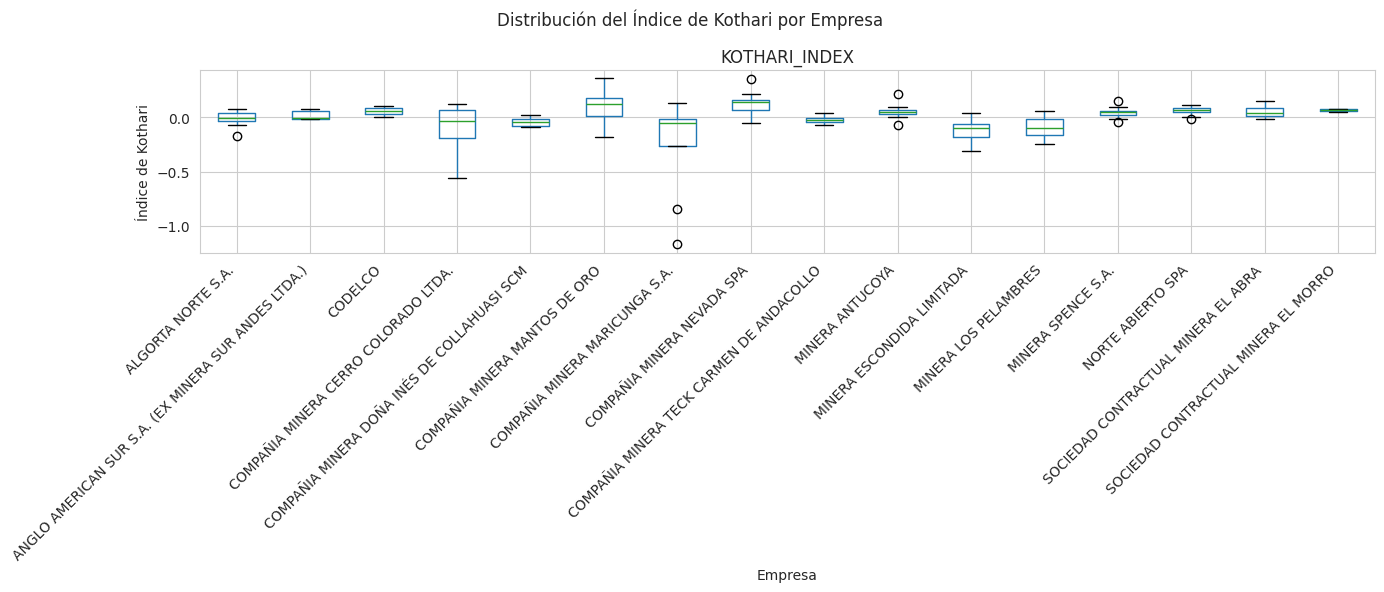

In [ ]:
# Visualizar el Índice de Kothari por empresa
fig, ax = plt.subplots(figsize=(14, 6))
df_regresion_limpio.boxplot(column='KOTHARI_INDEX', by='EMPRESA', ax=ax)
plt.suptitle('Distribución del Índice de Kothari por Empresa')
plt.xlabel('Empresa')
plt.ylabel('Índice de Kothari')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/docs/source/kothari_by_company.png', dpi=100, bbox_inches='tight')
plt.show()

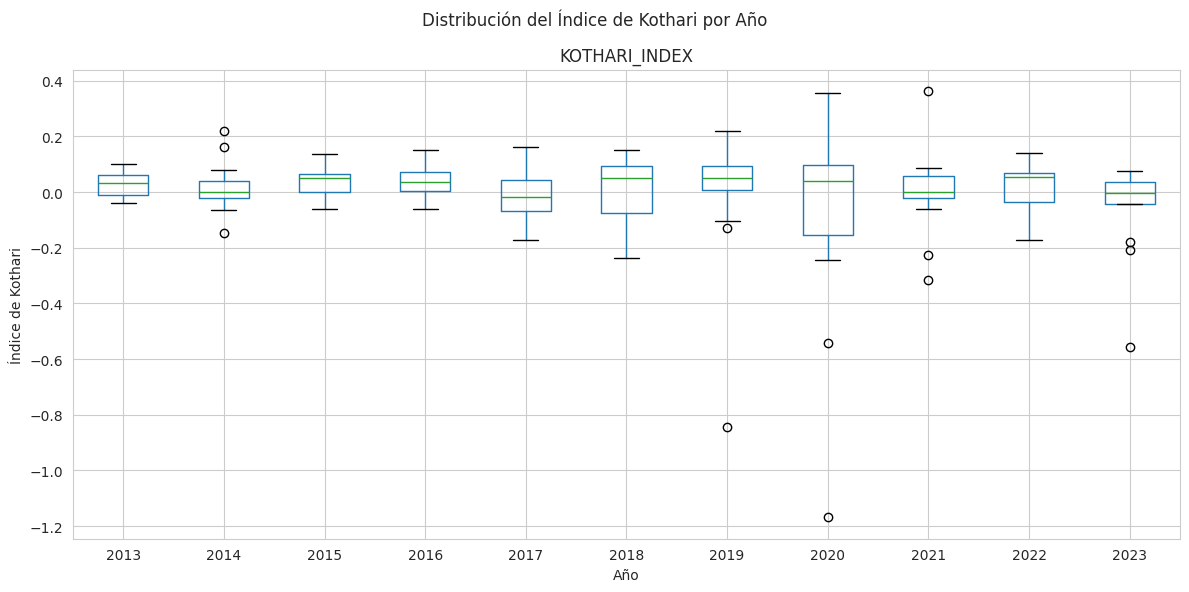

In [ ]:
# Visualizar el Índice de Kothari por año
fig, ax = plt.subplots(figsize=(12, 6))
df_regresion_limpio.boxplot(column='KOTHARI_INDEX', by='ANIO', ax=ax)
plt.suptitle('Distribución del Índice de Kothari por Año')
plt.xlabel('Año')
plt.ylabel('Índice de Kothari')
plt.tight_layout()
plt.savefig('/home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/docs/source/kothari_by_year.png', dpi=100, bbox_inches='tight')
plt.show()

## Guardar los resultados

In [ ]:
# Preparar el DataFrame con los resultados
df_kothari_results = df_regresion_limpio[[
    'EMPRESA', 'ANIO', 'Y', 'X1', 'X2', 'X3', 'X4', 
    'Y_predicho', 'KOTHARI_INDEX'
]].copy()

# Guardar el DataFrame en el catálogo de Kedro
catalog.save("kothari_results", df_kothari_results)
print("Resultados de la regresión de Kothari guardados en 'kothari_results'.")
print(f"Total de registros: {df_kothari_results.shape[0]}")

[11/09/25 15:34:59] INFO     Saving data to kothari_results (ParquetDataset)...                 ]8;id=888348;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=902206;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#445\445]8;;\

Resultados de la regresión de Kothari guardados en 'kothari_results'.
Total de registros: 157


In [ ]:
# Preparar un dataset completo para análisis posterior
# Incluye variables limpias, pesos y el índice de Kothari
df_analysis = df_regresion_limpio[[
    'EMPRESA', 'ANIO', 
    'Y', 'X1', 'X2', 'X3', 'X4',
    'Y_predicho', 'KOTHARI_INDEX',
    'peso_empresa', 'peso_muj_dir', 'peso_muj_ejec'
]].copy()

# Verificar que todas las columnas estén presentes
print("Columnas en el dataset de análisis:")
print(df_analysis.columns.tolist())
print(f"\nDimensiones: {df_analysis.shape[0]} filas × {df_analysis.shape[1]} columnas")

# Mostrar estadísticas básicas
print("\nEstadísticas del dataset de análisis:")
display(df_analysis.describe())

# Guardar el dataset en el catálogo de Kedro
catalog.save("kothari_analysis_data", df_analysis)
print("\nDataset de análisis guardado en 'kothari_analysis_data'.")
print(f"Total de registros: {df_analysis.shape[0]}")

Columnas en el dataset de análisis:
['EMPRESA', 'ANIO', 'Y', 'X1', 'X2', 'X3', 'X4', 'Y_predicho', 'KOTHARI_INDEX', 'peso_empresa', 'peso_muj_dir', 'peso_muj_ejec']

Dimensiones: 157 filas × 12 columnas

Estadísticas del dataset de análisis:


,ANIO,Y,X1,X2,X3,X4,Y_predicho,KOTHARI_INDEX,peso_empresa,peso_muj_dir,peso_muj_ejec
count,157.000000,157.000000,1.570000e+02,157.000000,157.000000,157.000000,157.000000,1.570000e+02,157.000000,115.000000,146.000000
mean,2018.057325,-0.102151,1.489036e-09,-0.001174,0.610295,0.342269,-0.102151,9.900078e-18,5.993148,17.563253,7.949234
std,3.006919,0.197177,1.610406e-09,0.128212,0.314186,21.534191,0.106111,1.661902e-01,10.502906,11.376484,6.688994
min,2013.000000,-1.231483,2.449539e-11,-0.565504,0.000000,-114.930104,-0.675637,-1.168834e+00,0.322877,2.439024,0.000000
25%,2016.000000,-0.134211,1.897895e-10,-0.039975,0.429257,-1.807704,-0.116470,-4.025620e-02,0.537882,8.235294,1.818182
50%,2018.000000,-0.065311,6.237031e-10,0.000000,0.716457,1.889448,-0.090537,2.896191e-02,1.289446,15.789474,8.411215
75%,2021.000000,-0.014780,2.502828e-09,0.052671,0.826797,9.158272,-0.056249,6.947705e-02,6.300341,27.343750,10.526316
max,2023.000000,0.513682,6.572332e-09,0.602822,2.082344,47.668436,0.157117,3.633798e-01,43.641923,35.227273,20.610687


                    INFO     Saving data to kothari_analysis_data (ParquetDataset)...           ]8;id=197129;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=709951;file:///home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/.venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#445\445]8;;\


Dataset de análisis guardado en 'kothari_analysis_data'.
Total de registros: 157


## Exportar resumen a markdown

In [ ]:
# Exportar los resultados a un archivo markdown
output_path = "/home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/docs/source/note_03_Kothari_Regression.md"

with open(output_path, "w", encoding="utf-8") as f:
    f.write("# Regresión de Kothari e Índice de Devengos Discrecionales\n\n")
    f.write("<!-- Este archivo documenta los resultados de la regresión de Kothari y el cálculo del índice de devengos discrecionales. -->\n\n")
    f.write("**Fuente:** notebooks/03_Calculate_Kothari_Index.ipynb\n\n")
    
    f.write("## Modelo de Regresión\n\n")
    f.write("Se implementó la regresión de Kothari conforme a la siguiente ecuación:\n\n")
    f.write("$$\\frac{TA_{i,t}}{A_{i,t-1}} = \\alpha_0 + \\alpha_1(\\frac{1}{A_{i,t-1}}) + \\alpha_2(\\frac{(\\Delta REV_{i,t} - \\Delta REC_{i,t})}{A_{i,t-1}}) + \\alpha_3(\\frac{PPE_{i,t}}{A_{i,t-1}}) + \\alpha_4 ROA_{i,t} + \\varepsilon_{i,t}$$\n\n")
    
    f.write("## Parámetros Estimados\n\n")
    f.write(f"| Parámetro | Estimación |\n")
    f.write(f"|-----------|------------|\n")
    f.write(f"| Intercepto (α₀) | {intercepto:.6f} |\n")
    f.write(f"| X1 (α₁) | {coeficientes[0]:.6f} |\n")
    f.write(f"| X2 (α₂) | {coeficientes[1]:.6f} |\n")
    f.write(f"| X3 (α₃) | {coeficientes[2]:.6f} |\n")
    f.write(f"| X4 (α₄) | {coeficientes[3]:.6f} |\n")
    f.write(f"| R² | {r2:.6f} |\n")
    f.write(f"| Observaciones | {len(Y)} |\n\n")
    
    f.write("## Índice de Kothari (Devengos Discrecionales)\n\n")
    f.write("El Índice de Kothari corresponde a los residuos de la regresión ($\\varepsilon_{i,t}$), que representan la parte de los devengos totales no explicada por el modelo.\n\n")
    f.write(f"| Estadístico | Valor |\n")
    f.write(f"|-------------|-------|\n")
    f.write(f"| Media | {df_regresion_limpio['KOTHARI_INDEX'].mean():.6f} |\n")
    f.write(f"| Mediana | {df_regresion_limpio['KOTHARI_INDEX'].median():.6f} |\n")
    f.write(f"| Desviación Estándar | {df_regresion_limpio['KOTHARI_INDEX'].std():.6f} |\n")
    f.write(f"| Mínimo | {df_regresion_limpio['KOTHARI_INDEX'].min():.6f} |\n")
    f.write(f"| Máximo | {df_regresion_limpio['KOTHARI_INDEX'].max():.6f} |\n")
    f.write(f"| Skewness | {stats.skew(df_regresion_limpio['KOTHARI_INDEX']):.6f} |\n")
    f.write(f"| Kurtosis | {stats.kurtosis(df_regresion_limpio['KOTHARI_INDEX']):.6f} |\n\n")
    
    f.write("## Interpretación\n\n")
    f.write("- **Valores positivos del Índice de Kothari**: Indican que los devengos reales superan lo que el modelo predice como normal, sugiriendo posible manipulación de ganancias hacia el alza.\n")
    f.write("- **Valores negativos del Índice de Kothari**: Indican que los devengos reales son menores que lo predicho por el modelo, sugiriendo posible manipulación hacia la baja.\n")
    f.write("- **Valores cercanos a cero**: Indican que los devengos se comportan como lo esperado por el modelo normal.\n\n")
    f.write("*Generado automáticamente desde el notebook.*\n")

print(f"Resumen guardado en: {output_path}")

Resumen guardado en: /home/gabriel/Escritorio/Proyectos/UBO/Erik_Escalona/kotari_proyecto/kotari-gender-data-analysis/docs/source/note_03_Kothari_Regression.md
